In [ ]:
import os
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import pickle as p
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Input, Masking

In [ ]:
file_path = "/content/drive/MyDrive/DLA6/CV_Data01"
classes = ['ba', 'hai','hI', 'ka','ni']
data_split = ['Test', 'Train']

In [ ]:
Y_train = []
X_train = []
X_test = []
Y_test = []

dir_list = os.listdir(file_path)
print(dir_list)
for j in data_split:
    for i in classes:
        for filename in glob.glob(os.path.join(file_path + '/' + i + '/' + j, '*.mfcc')):
            with open(filename, 'r') as f:
                if (j == "Train"):
                    # print(filename)
                    f = open(filename)
                    parsed = f.readlines()
                    parsed = [np.array([float(val) for val in line.split(" ") if val!="\n"]) for line in parsed]
                    X_train.append(np.array(parsed))
                    Y_train.append(str(i))
                if (j == 'Test'):
                    # print(filename)
                    f = open(filename)
                    parsed = f.readlines()
                    parsed = [np.array([float(val) for val in line.split(" ") if val!="\n"]) for line in parsed]
                    X_test.append(np.array(parsed))
                    Y_test.append(str(i))
print("Training Set has {} samples each with dimension {} but variable length".format(len(X_train),X_train[0][0].shape))
print("Test Set has {} samples each with dimension {} but variable length".format(len(X_test),X_test[0][0].shape))

# padding input
max_len = max([len(val) for val in X_train])
print("Max_seq length: ",max_len)
def padd_it(data):
    for i in range(len(data)):
        if len(data[i]) <= max_len:
            seq = np.repeat(np.array([-1]*39).reshape(-1,39),int(max_len-len(data[i])),0)
            data[i] = np.append(data[i],seq,axis=0)
    return data
# data preprocessing steps to prepare the input data for training and testing a model
print("Before Padding shape of first element in train is {}".format((X_train[0]).shape))
X_test = np.asarray(padd_it(X_test))
X_train = np.asarray(padd_it(X_train))
print("After Padding shape of first element in train is {}".format((X_train[0]).shape))

['ni', 'ka', 'hai', 'hI', 'ba']
Training Set has 1570 samples each with dimension (39,) but variable length
Test Set has 393 samples each with dimension (39,) but variable length
Max_seq length:  78
Before Padding shape of first element in train is (16, 39)
After Padding shape of first element in train is (78, 39)


In [ ]:
Y_train=np.array(Y_train).reshape(-1, 1)
Y_test=np.array(Y_test).reshape(-1, 1)

from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
#define ordinal encoding
encoder = OrdinalEncoder()
# transform data
yt= encoder.fit_transform(Y_train)
ytest= encoder.fit_transform(Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 78, 39)            0         
                                                                 
 lstm (LSTM)                 (None, 78, 32)            9216      
                                                                 
 dropout (Dropout)           (None, 78, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 78, 32)            8320      
                                                                 
 dropout_1 (Dropout)         (None, 78, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

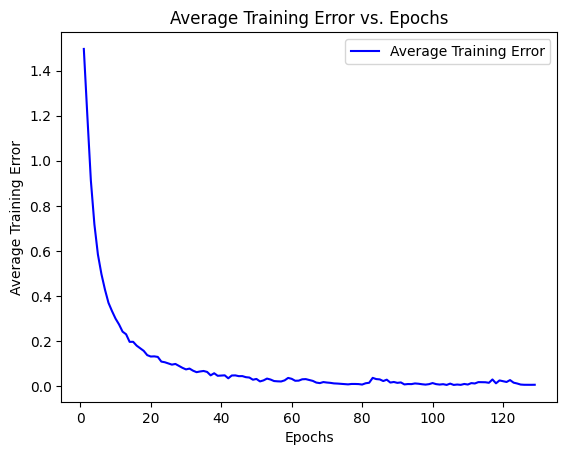

In [ ]:
#ModelArchitecture 1

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(32, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(32, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(32))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv425.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 78, 39)            0         
                                                                 
 lstm_3 (LSTM)               (None, 78, 64)            26624     
                                                                 
 dropout_3 (Dropout)         (None, 78, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 78, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 78, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

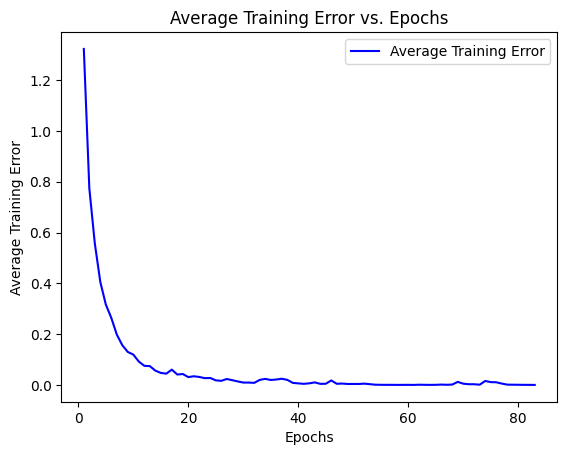

In [ ]:
#ModelArchitecture 2

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(64, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(64, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(64))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv625.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 78, 39)            0         
                                                                 
 lstm_6 (LSTM)               (None, 78, 128)           86016     
                                                                 
 dropout_6 (Dropout)         (None, 78, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 78, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 78, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 128)              

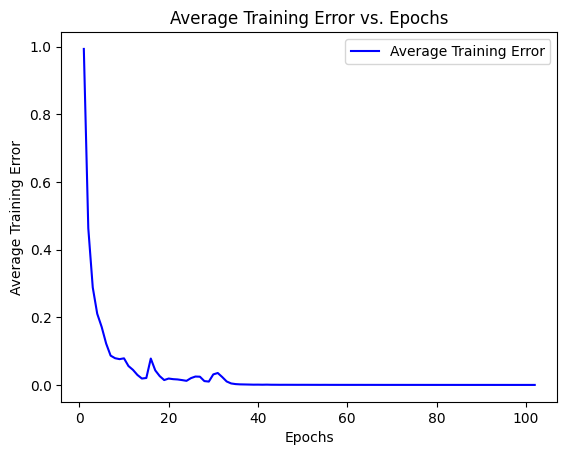

In [ ]:
#ModelArchitecture 3

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(128, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(128, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(128))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=25)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=1500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv525.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, 78, 39)            0         
                                                                 
 lstm_9 (LSTM)               (None, 78, 32)            9216      
                                                                 
 dropout_9 (Dropout)         (None, 78, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 78, 32)            8320      
                                                                 
 dropout_10 (Dropout)        (None, 78, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_11 (Dropout)        (None, 32)               

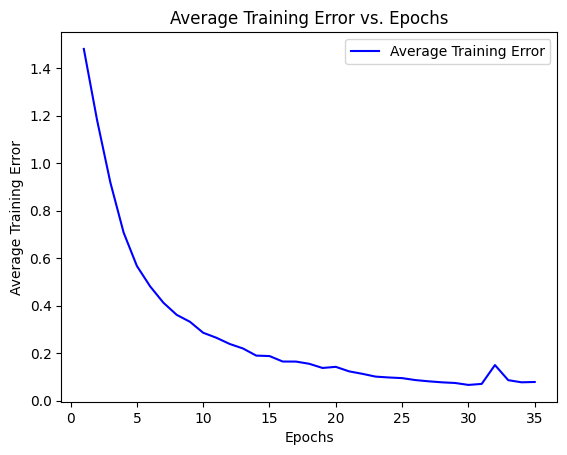

In [ ]:
#ModelArchitecture 1

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(32, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(32, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(32))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv4.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 78, 39)            0         
                                                                 
 lstm_12 (LSTM)              (None, 78, 64)            26624     
                                                                 
 dropout_12 (Dropout)        (None, 78, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 78, 64)            33024     
                                                                 
 dropout_13 (Dropout)        (None, 78, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_14 (Dropout)        (None, 64)               

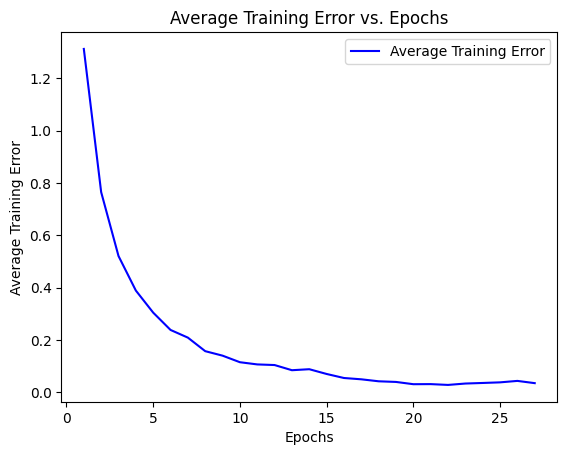

In [ ]:
#ModelArchitecture 2

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(64, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(64, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(64))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv5.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()





Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_5 (Masking)         (None, 78, 39)            0         
                                                                 
 lstm_15 (LSTM)              (None, 78, 128)           86016     
                                                                 
 dropout_15 (Dropout)        (None, 78, 128)           0         
                                                                 
 lstm_16 (LSTM)              (None, 78, 128)           131584    
                                                                 
 dropout_16 (Dropout)        (None, 78, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 128)              

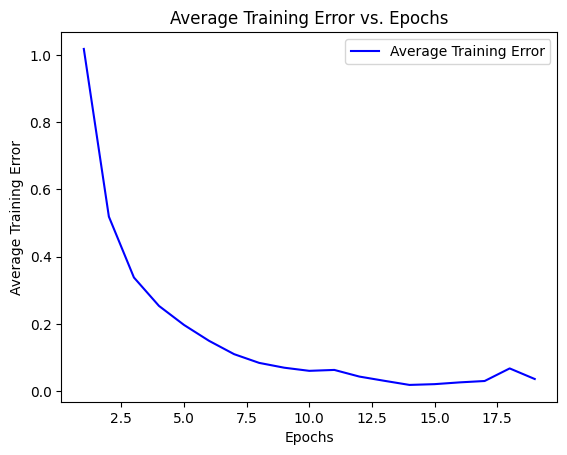

In [ ]:
#ModelArchitecture 3

CV_LSTM_Model1=Sequential()
CV_LSTM_Model1.add(Masking(mask_value=-1,input_shape=X_train.shape[1:]))  # to mask values other then -1 (padded value that shall be ignored)
CV_LSTM_Model1.add(LSTM(128, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(128, return_sequences=True))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(LSTM(128))
CV_LSTM_Model1.add(Dropout(0.2))
CV_LSTM_Model1.add(Dense(5, activation='softmax'))
CV_LSTM_Model1.summary()

CV_LSTM_Model1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001,patience=5)
history = CV_LSTM_Model1.fit(X_train, yt, batch_size=128,callbacks=[callback] ,epochs=500,verbose=1)

CV_LSTM_Model1.save('/content/drive/MyDrive/CV_RNN_Model/cv6.h5')


#Evaluating the model
print('\nEvaluation of model on train data:')
trainAcc1=CV_LSTM_Model1.evaluate(x=X_train,y=yt,batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(trainAcc1)
print('\nEvaluation of model on test data:')
testAcc1=CV_LSTM_Model1.evaluate(x=X_test, y=ytest, batch_size=1, verbose="auto",callbacks=None)
print(CV_LSTM_Model1.metrics_names)
print(testAcc1)
print('\nPredictions for test data:')
testProb1=CV_LSTM_Model1.predict(X_test, batch_size=1, verbose="auto", callbacks=None)
pred1=np.argmax(testProb1,axis=1)
confusionMatrix1=tf.math.confusion_matrix(ytest,pred1)
print(confusionMatrix1)

# Extract the loss values from the history object
training_loss = history.history['loss']

#Plot the training loss against epochs
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Average Training Error')
plt.xlabel('Epochs')
plt.ylabel('Average Training Error')
plt.title('Average Training Error vs. Epochs')
plt.legend()
plt.show()



